In [1]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import decimate

from audio import AudioDataset, AudioFile

In [2]:
# Functions
def boxprint(s):
    """Print string surrounded by lines"""
    l = '-' * len(s)
    print(f'{l}\n{s}\n{l}')

## Fix mislabeled data

In [3]:
def log_xscale(audio, ax, min_freq):
    max_freq = audio.nyquist
    x_step = audio.fundamental_freq
    first_fundamental = audio.fundamental_freq * (1 + (min_freq//audio.fundamental_freq))
    nth_fundamental =  min(max_freq, first_fundamental+(x_step*10))
    xtick_freqs = range(first_fundamental, nth_fundamental+1, x_step)
    ax.set_xticks([audio._log_to_logidx(audio._freq_to_log(x)) - 96000 for x in xtick_freqs])
    ax.set_xticklabels(xtick_freqs)

In [4]:
def visualise(audiofile, min_freq=1, resolution=22031):
    audiofile.audio_to_spectrogram(spec_thresh=3.5)
    audiofile.spectrogram_to_log(audiofile.spectrogram, resolution=resolution)
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    min_idx = audiofile._log_to_logidx(audiofile._freq_to_log(min_freq))
    ax.plot(audiofile.spectrogram_log[0][min_idx:])
    log_xscale(audiofile, ax, min_freq)
    plt.show()
    audiofile.play_audio(autoplay=True)

In [5]:
def iterate_sounds(folder, instrument_name, resolution=22031, min_freq=20):
    """
    Iterate through the sounds corresponding to an instrument_id
    and indicate whether they are good training data or not
    """
    dataset = AudioDataset(f'../data/raw/nsynth-{folder}')
    data_filter = {}
    
    for instrument in dataset.file_names_nested[instrument_name].keys():
        boxprint(f'Instrument: {instrument}')
        num_files = len(dataset.file_names_nested[instrument_name][instrument])
        for i, file_name in enumerate(dataset.file_names_nested[instrument_name][instrument]):
            if data_filter.get(instrument) is None:
                # Load file
                path, info = dataset.get_filepath(file_name=file_name)
                try:
                    audiofile = AudioFile(path, info)
                    print(f'\n- {file_name}', end='\r')
                except Exception as exc:
                    print(exc)
                    continue
                # Plot spectrogram and play audio
                visualise(audiofile, min_freq, resolution)

                # User input
                is_last_item = (i == (num_files-1))
                valid_input = False
                while not valid_input:
                    keep = input('Keep instrument?')
                    if keep == '':
                        if not(is_last_item and (data_filter.get(instrument) is None)):
                            valid_input = True
                        else:
                            print('Last item - make a choice')
                    elif keep == 'y':
                        data_filter[instrument] = 1
                        valid_input = True
                    elif keep == 'n':
                        data_filter[instrument] = 0
                        valid_input = True
                
    print('\n\nFinished')
    # Create dataframe
    df_filter = pd.Series(data_filter).reset_index()
    df_filter.columns = ['instrument', 'keep']
    # Save
    out_file = f'../data/interim/{folder}/{instrument_name}-filter.csv'
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    df_filter.to_csv(out_file, header=True, index=False)
    print(f'Saved filter to {out_file}')

### Iterate for this instrument

---------------------------------
Instrument: keyboard_acoustic_010
---------------------------------



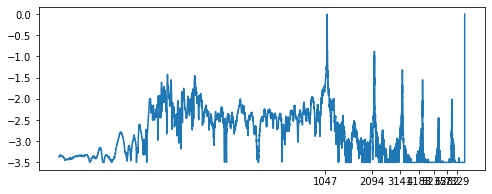

Keep instrument?y


Finished
Saved filter to ../data/interim/train/keyboard_acoustic-filter.csv


In [6]:
folder = 'train'
instrument_name = 'keyboard_acoustic'
iterate_sounds(folder, instrument_name)

duplicates:
- flute_acoustic_013-096-075 == flute_acoustic_013-096-100
- vocal_acoustic_015-067-025 == vocal_acoustic_015-067-127

wrong:
- flute_acoustic_034
- reed_acoustic_055
- reed_acoustic_023
- reed_acoustic_011
- brass_acoustic_046

 mallet_acoustic_060-088-075 is strong due to echo
 
 |-> 0db should not be the maximum for all sounds